In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import warnings
import time
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Check available libraries
libraries_status = {
    'TF-IDF': True,  # Always available (sklearn)
    'Word2Vec': False,
    'GloVe': False,
    'FastText': False,
    'SBERT': False
}

try:
    from gensim.models import Word2Vec
    libraries_status['Word2Vec'] = True
    print("✓ Word2Vec (gensim) available")
except ImportError:
    print("✗ Word2Vec not available")

try:
    from gensim.models import FastText
    libraries_status['FastText'] = True
    print("✓ FastText (gensim) available")
except ImportError:
    print("✗ FastText not available")

try:
    from sentence_transformers import SentenceTransformer
    libraries_status['SBERT'] = True
    print("✓ SBERT (sentence-transformers) available")
except ImportError:
    print("✗ SBERT not available - install with: pip install sentence-transformers")

# GloVe uses same as Word2Vec for demo
libraries_status['GloVe'] = libraries_status['Word2Vec']
print(f"✓ GloVe (simulated with Word2Vec) {'available' if libraries_status['GloVe'] else 'not available'}")

print("\n" + "="*80)
print("Summary:")
for method, available in libraries_status.items():
    status = "✓ Available" if available else "✗ Not Available"
    print(f"  {method:<15} {status}")

✓ Word2Vec (gensim) available
✓ FastText (gensim) available
✓ SBERT (sentence-transformers) available
✓ GloVe (simulated with Word2Vec) available

Summary:
  TF-IDF          ✓ Available
  Word2Vec        ✓ Available
  GloVe           ✓ Available
  FastText        ✓ Available
  SBERT           ✓ Available


In [3]:
# Load the data
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample data:")
df.head()

Dataset shape: (104, 5)
Columns: ['id', 'job_title', 'location', 'connection', 'fit']

Sample data:


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources prof...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


## Common Utilities

Define common helper functions used across all methods.

In [4]:
def preprocess_text_basic(text):
    """Basic preprocessing for most methods."""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    return text

def normalize_connections(connections_series):
    """Normalize connection counts."""
    def parse_connection(conn):
        if pd.isna(conn):
            return 0
        conn_str = str(conn).strip()
        if '500+' in conn_str:
            return 500
        try:
            return int(conn_str)
        except:
            return 0
    
    connections_numeric = connections_series.apply(parse_connection)
    max_conn = connections_numeric.max()
    if max_conn > 0:
        return connections_numeric / max_conn
    return connections_numeric

print("Utility functions defined")

Utility functions defined


## Run All Embedding Methods

We'll run each method and collect rankings and scores.

In [5]:
# Initialize keywords
keywords = "aspiring human resources seeking human resources"
results = {}
timing = {}

print(f"Target keywords: '{keywords}'")
print("="*100)

Target keywords: 'aspiring human resources seeking human resources'


### 1. TF-IDF (Baseline)

In [6]:
# TF-IDF Method
start_time = time.time()

df_copy = df.copy()
df_copy['processed_title'] = df_copy['job_title'].apply(preprocess_text_basic)

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 3),
    min_df=1,
    lowercase=True
)

all_texts = [keywords] + df_copy['processed_title'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

keyword_vector = tfidf_matrix[0:1]
candidate_vectors = tfidf_matrix[1:]

similarities = cosine_similarity(keyword_vector, candidate_vectors).flatten()

# Add connections
connection_scores = normalize_connections(df_copy['connection'])
final_scores = 0.8 * similarities + 0.2 * connection_scores

df_copy['fit_tfidf'] = final_scores
df_copy = df_copy.sort_values('fit_tfidf', ascending=False).reset_index(drop=True)
df_copy['rank_tfidf'] = range(1, len(df_copy) + 1)

results['TF-IDF'] = df_copy[['id', 'job_title', 'fit_tfidf', 'rank_tfidf']].copy()
timing['TF-IDF'] = time.time() - start_time

print(f"✓ TF-IDF complete ({timing['TF-IDF']:.4f}s)")
print(f"  Top candidate: {df_copy.iloc[0]['job_title']}")
print(f"  Score range: {df_copy['fit_tfidf'].min():.4f} - {df_copy['fit_tfidf'].max():.4f}")

✓ TF-IDF complete (0.0301s)
  Top candidate: Seeking Human Resources Opportunities
  Score range: 0.0008 - 0.4610


### 2. Word2Vec

In [7]:
# Word2Vec Method
if libraries_status['Word2Vec']:
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess
    
    start_time = time.time()
    
    df_copy = df.copy()
    
    # Tokenize
    tokenized_titles = [simple_preprocess(preprocess_text_basic(title)) 
                       for title in df_copy['job_title']]
    tokenized_keywords = [simple_preprocess(preprocess_text_basic(keywords))]
    all_documents = tokenized_keywords + tokenized_titles
    
    # Train Word2Vec
    w2v_model = Word2Vec(
        sentences=all_documents,
        vector_size=100,
        window=5,
        min_count=1,
        workers=4,
        epochs=100,
        sg=1
    )
    
    # Get document vectors
    def get_doc_vector(tokens, model, vector_size=100):
        vectors = []
        for token in tokens:
            if token in model.wv:
                vectors.append(model.wv[token])
        if len(vectors) == 0:
            return np.zeros(vector_size)
        return np.mean(vectors, axis=0)
    
    keyword_vector = get_doc_vector(tokenized_keywords[0], w2v_model).reshape(1, -1)
    job_vectors = np.array([get_doc_vector(tokens, w2v_model) for tokens in tokenized_titles])
    
    similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
    connection_scores = normalize_connections(df_copy['connection'])
    final_scores = 0.8 * similarities + 0.2 * connection_scores
    
    df_copy['fit_word2vec'] = final_scores
    df_copy = df_copy.sort_values('fit_word2vec', ascending=False).reset_index(drop=True)
    df_copy['rank_word2vec'] = range(1, len(df_copy) + 1)
    
    results['Word2Vec'] = df_copy[['id', 'job_title', 'fit_word2vec', 'rank_word2vec']].copy()
    timing['Word2Vec'] = time.time() - start_time
    
    print(f"✓ Word2Vec complete ({timing['Word2Vec']:.4f}s)")
    print(f"  Top candidate: {df_copy.iloc[0]['job_title']}")
    print(f"  Score range: {df_copy['fit_word2vec'].min():.4f} - {df_copy['fit_word2vec'].max():.4f}")
else:
    print("✗ Word2Vec skipped - library not available")

✓ Word2Vec complete (0.2951s)
  Top candidate: Seeking Human Resources HRIS and Generalist Positions
  Score range: 0.3440 - 0.9963


### 3. GloVe (Simulated with Word2Vec)

In [8]:
# GloVe Method (using Word2Vec as proxy)
if libraries_status['GloVe']:
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess
    
    start_time = time.time()
    
    df_copy = df.copy()
    
    # Same as Word2Vec for this demo
    tokenized_titles = [simple_preprocess(preprocess_text_basic(title)) 
                       for title in df_copy['job_title']]
    tokenized_keywords = [simple_preprocess(preprocess_text_basic(keywords))]
    all_documents = tokenized_keywords + tokenized_titles
    
    glove_model = Word2Vec(
        sentences=all_documents,
        vector_size=100,
        window=5,
        min_count=1,
        workers=4,
        epochs=100,
        sg=1
    )
    
    keyword_vector = get_doc_vector(tokenized_keywords[0], glove_model).reshape(1, -1)
    job_vectors = np.array([get_doc_vector(tokens, glove_model) for tokens in tokenized_titles])
    
    similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
    connection_scores = normalize_connections(df_copy['connection'])
    final_scores = 0.8 * similarities + 0.2 * connection_scores
    
    df_copy['fit_glove'] = final_scores
    df_copy = df_copy.sort_values('fit_glove', ascending=False).reset_index(drop=True)
    df_copy['rank_glove'] = range(1, len(df_copy) + 1)
    
    results['GloVe'] = df_copy[['id', 'job_title', 'fit_glove', 'rank_glove']].copy()
    timing['GloVe'] = time.time() - start_time
    
    print(f"✓ GloVe complete ({timing['GloVe']:.4f}s)")
    print(f"  Top candidate: {df_copy.iloc[0]['job_title']}")
    print(f"  Score range: {df_copy['fit_glove'].min():.4f} - {df_copy['fit_glove'].max():.4f}")
else:
    print("✗ GloVe skipped - library not available")

✓ GloVe complete (0.2960s)
  Top candidate: Seeking Human Resources HRIS and Generalist Positions
  Score range: 0.3440 - 0.9963


### 4. FastText

In [9]:
# FastText Method
if libraries_status['FastText']:
    from gensim.models import FastText
    from gensim.utils import simple_preprocess
    
    start_time = time.time()
    
    df_copy = df.copy()
    
    tokenized_titles = [simple_preprocess(preprocess_text_basic(title)) 
                       for title in df_copy['job_title']]
    tokenized_keywords = [simple_preprocess(preprocess_text_basic(keywords))]
    all_documents = tokenized_keywords + tokenized_titles
    
    # Train FastText
    ft_model = FastText(
        sentences=all_documents,
        vector_size=100,
        window=5,
        min_count=1,
        workers=4,
        epochs=100,
        sg=1,
        min_n=3,
        max_n=6
    )
    
    def get_doc_vector_ft(tokens, model, vector_size=100):
        vectors = []
        for token in tokens:
            try:
                vectors.append(model.wv[token])
            except KeyError:
                pass
        if len(vectors) == 0:
            return np.zeros(vector_size)
        return np.mean(vectors, axis=0)
    
    keyword_vector = get_doc_vector_ft(tokenized_keywords[0], ft_model).reshape(1, -1)
    job_vectors = np.array([get_doc_vector_ft(tokens, ft_model) for tokens in tokenized_titles])
    
    similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
    connection_scores = normalize_connections(df_copy['connection'])
    final_scores = 0.8 * similarities + 0.2 * connection_scores
    
    df_copy['fit_fasttext'] = final_scores
    df_copy = df_copy.sort_values('fit_fasttext', ascending=False).reset_index(drop=True)
    df_copy['rank_fasttext'] = range(1, len(df_copy) + 1)
    
    results['FastText'] = df_copy[['id', 'job_title', 'fit_fasttext', 'rank_fasttext']].copy()
    timing['FastText'] = time.time() - start_time
    
    print(f"✓ FastText complete ({timing['FastText']:.4f}s)")
    print(f"  Top candidate: {df_copy.iloc[0]['job_title']}")
    print(f"  Score range: {df_copy['fit_fasttext'].min():.4f} - {df_copy['fit_fasttext'].max():.4f}")
else:
    print("✗ FastText skipped - library not available")

✓ FastText complete (2.0559s)
  Top candidate: Seeking Human Resources HRIS and Generalist Positions
  Score range: 0.3988 - 0.9945


### 5. Sentence-BERT

In [10]:
# SBERT Method
if libraries_status['SBERT']:
    from sentence_transformers import SentenceTransformer
    
    start_time = time.time()
    
    df_copy = df.copy()
    
    # Load SBERT model
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Get embeddings
    all_texts = [keywords] + df_copy['job_title'].tolist()
    all_embeddings = sbert_model.encode(all_texts, convert_to_numpy=True, show_progress_bar=False)
    
    keyword_vector = all_embeddings[0:1]
    job_vectors = all_embeddings[1:]
    
    similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
    connection_scores = normalize_connections(df_copy['connection'])
    final_scores = 0.8 * similarities + 0.2 * connection_scores
    
    df_copy['fit_sbert'] = final_scores
    df_copy = df_copy.sort_values('fit_sbert', ascending=False).reset_index(drop=True)
    df_copy['rank_sbert'] = range(1, len(df_copy) + 1)
    
    results['SBERT'] = df_copy[['id', 'job_title', 'fit_sbert', 'rank_sbert']].copy()
    timing['SBERT'] = time.time() - start_time
    
    print(f"✓ SBERT complete ({timing['SBERT']:.4f}s)")
    print(f"  Top candidate: {df_copy.iloc[0]['job_title']}")
    print(f"  Score range: {df_copy['fit_sbert'].min():.4f} - {df_copy['fit_sbert'].max():.4f}")
else:
    print("✗ SBERT skipped - library not available")

✓ SBERT complete (5.8973s)
  Top candidate: Seeking Human Resources Opportunities
  Score range: 0.0778 - 0.8225


## Comprehensive Comparison

Now let's merge all results and compare.

In [11]:
# Merge all results
comparison_df = results['TF-IDF'][['id', 'job_title', 'fit_tfidf', 'rank_tfidf']].copy()

for method, df_result in results.items():
    if method == 'TF-IDF':
        continue
    
    # Extract fit and rank columns
    fit_col = [col for col in df_result.columns if col.startswith('fit_')][0]
    rank_col = [col for col in df_result.columns if col.startswith('rank_')][0]
    
    comparison_df = comparison_df.merge(
        df_result[['id', fit_col, rank_col]],
        on='id',
        how='left'
    )

print("All results merged!")
print(f"Comparison dataframe shape: {comparison_df.shape}")
print(f"\nColumns: {comparison_df.columns.tolist()}")

All results merged!
Comparison dataframe shape: (104, 12)

Columns: ['id', 'job_title', 'fit_tfidf', 'rank_tfidf', 'fit_word2vec', 'rank_word2vec', 'fit_glove', 'rank_glove', 'fit_fasttext', 'rank_fasttext', 'fit_sbert', 'rank_sbert']


In [12]:
# Display top 20 candidates across all methods
print("Top 20 Candidates - All Methods Comparison:")
print("="*150)

display_cols = ['job_title', 'rank_tfidf']
for method in results.keys():
    if method != 'TF-IDF':
        rank_col = [col for col in comparison_df.columns if col.startswith(f'rank_{method.lower()}')][0]
        display_cols.append(rank_col)

display_df = comparison_df[display_cols].head(20)
display_df.index = range(1, len(display_df) + 1)
display(display_df)

Top 20 Candidates - All Methods Comparison:


,job_title,rank_tfidf,rank_word2vec,rank_glove,rank_fasttext,rank_sbert
1,Seeking Human Resources Opportunities,1,14,14,19,1
2,Seeking Human Resources Opportunities,2,15,15,20,2
3,Seeking Human Resources HRIS and Generalist Positions,3,1,1,1,3
4,Seeking Human Resources HRIS and Generalist Positions,4,2,2,2,4
5,Seeking Human Resources HRIS and Generalist Positions,5,3,3,3,5
6,Seeking Human Resources HRIS and Generalist Positions,6,4,4,4,6
7,Aspiring Human Resources Management student seeking an internship,7,7,7,7,7
8,Aspiring Human Resources Management student seeking an internship,8,6,6,6,8
9,Seeking Human Resources Opportunities. Open to travel and relocation.,9,16,16,22,34
10,"Nortia Staffing is seeking Human Resources, Payroll & Administrative Professionals!! (408) 709-...",10,17,17,12,56


## Performance Comparison


Computational Performance:
Method          Time (seconds)       Relative Speed
--------------------------------------------------------------------------------
TF-IDF          0.0301               1.00x
Word2Vec        0.2951               9.79x
GloVe           0.2960               9.82x
FastText        2.0559               68.19x
SBERT           5.8973               195.61x


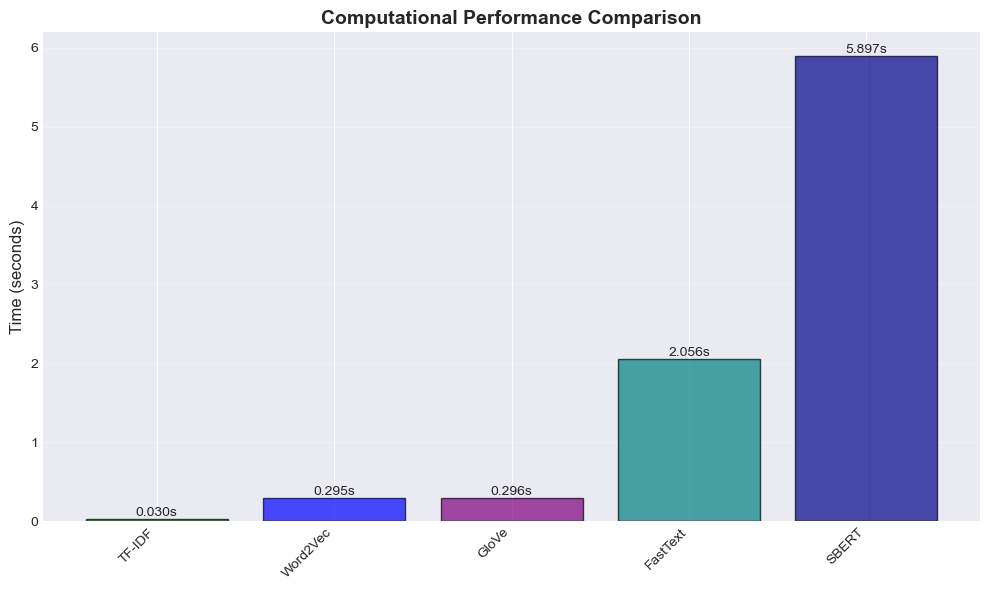

In [13]:
# Timing comparison
print("\nComputational Performance:")
print("="*80)
print(f"{'Method':<15} {'Time (seconds)':<20} {'Relative Speed'}")
print("-"*80)

baseline_time = timing['TF-IDF']
for method, time_taken in sorted(timing.items(), key=lambda x: x[1]):
    relative = time_taken / baseline_time
    print(f"{method:<15} {time_taken:<20.4f} {relative:.2f}x")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
methods = list(timing.keys())
times = [timing[m] for m in methods]
colors = ['green', 'blue', 'purple', 'teal', 'darkblue'][:len(methods)]

bars = ax.bar(methods, times, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Computational Performance Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}s',
            ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Score Distribution Comparison

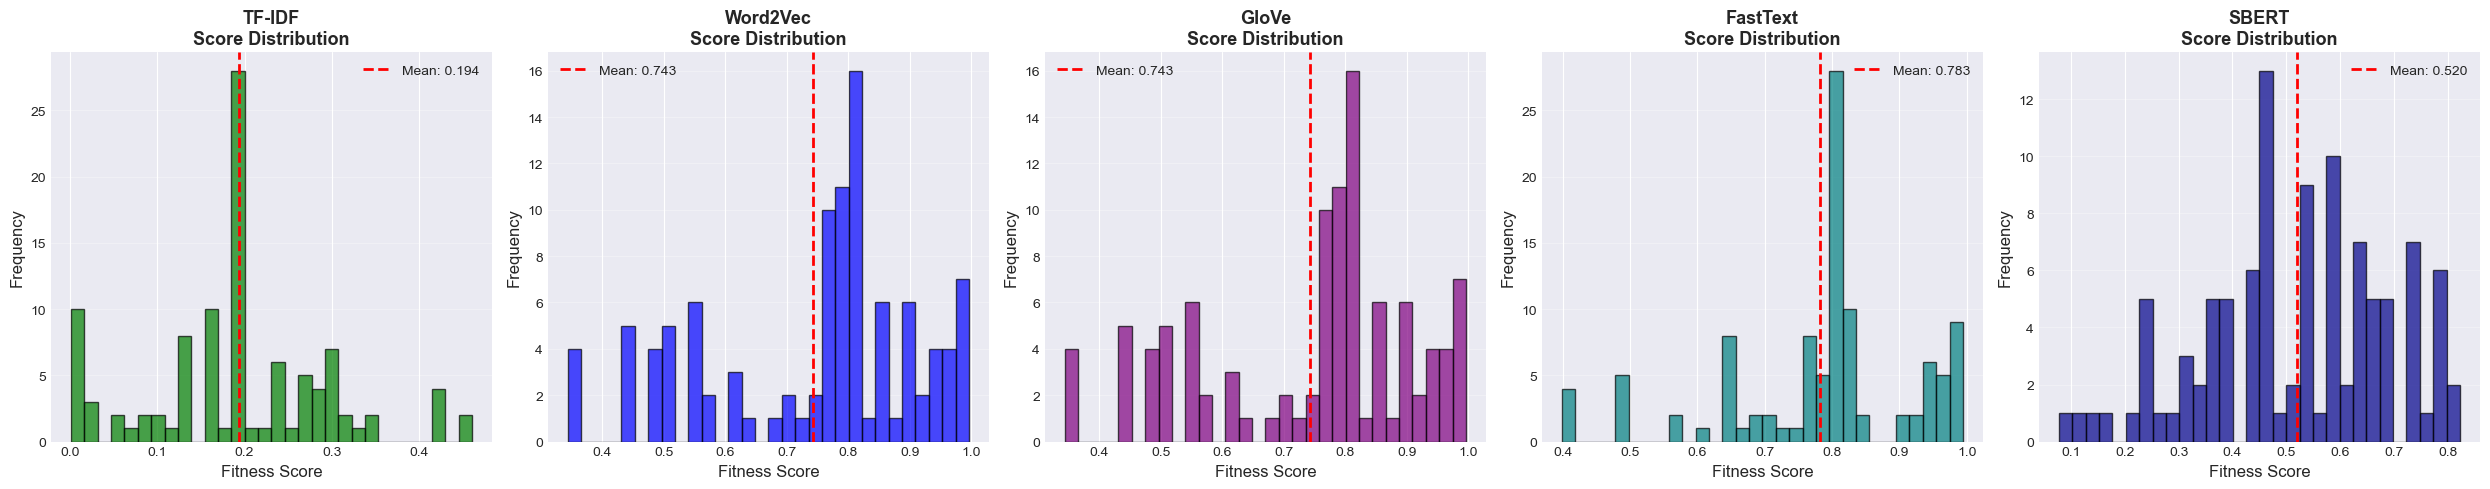

In [14]:
# Score distributions
available_methods = list(results.keys())
n_methods = len(available_methods)

fig, axes = plt.subplots(1, n_methods, figsize=(5*n_methods, 5))
if n_methods == 1:
    axes = [axes]

colors_map = {
    'TF-IDF': 'green',
    'Word2Vec': 'blue',
    'GloVe': 'purple',
    'FastText': 'teal',
    'SBERT': 'darkblue'
}

# Method name to column suffix mapping (handles hyphen in TF-IDF)
method_to_col = {
    'TF-IDF': 'tfidf',
    'Word2Vec': 'word2vec',
    'GloVe': 'glove',
    'FastText': 'fasttext',
    'SBERT': 'sbert'
}

for idx, method in enumerate(available_methods):
    col_suffix = method_to_col[method]
    fit_col = f'fit_{col_suffix}'
    scores = comparison_df[fit_col]
    
    axes[idx].hist(scores, bins=30, alpha=0.7, color=colors_map[method], edgecolor='black')
    axes[idx].set_xlabel('Fitness Score', fontsize=12)
    axes[idx].set_ylabel('Frequency', fontsize=12)
    axes[idx].set_title(f'{method}\nScore Distribution', fontsize=13, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add statistics
    mean_score = scores.mean()
    axes[idx].axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.3f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## Ranking Agreement Analysis

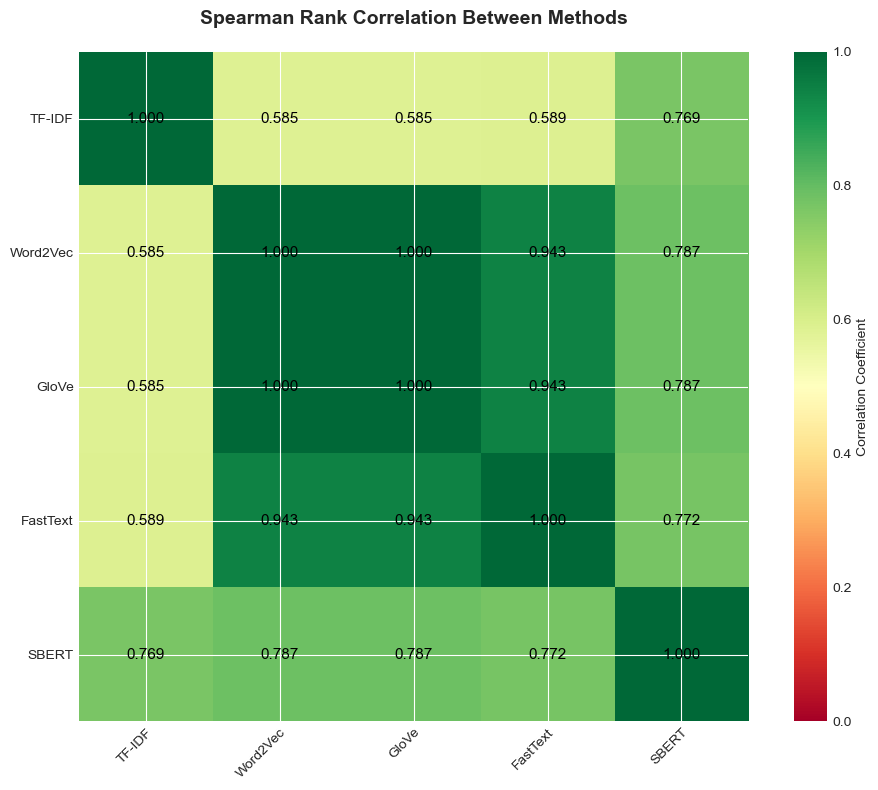


Correlation Matrix (Spearman):

TF-IDF:
  vs Word2Vec: 0.5847
  vs GloVe: 0.5847
  vs FastText: 0.5895
  vs SBERT: 0.7694

Word2Vec:
  vs GloVe: 1.0000
  vs FastText: 0.9432
  vs SBERT: 0.7875

GloVe:
  vs FastText: 0.9432
  vs SBERT: 0.7875

FastText:
  vs SBERT: 0.7716

SBERT:


In [15]:
# Calculate pairwise correlations between methods
from scipy.stats import spearmanr

# Get all fit columns
fit_cols = [col for col in comparison_df.columns if col.startswith('fit_')]
method_names = [col.replace('fit_', '').upper().replace('TFIDF', 'TF-IDF').replace('WORD2VEC', 'Word2Vec').replace('GLOVE', 'GloVe').replace('FASTTEXT', 'FastText').replace('SBERT', 'SBERT') for col in fit_cols]

# Create correlation matrix
n = len(fit_cols)
correlation_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            correlation_matrix[i, j] = 1.0
        else:
            corr, _ = spearmanr(comparison_df[fit_cols[i]], comparison_df[fit_cols[j]])
            correlation_matrix[i, j] = corr

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(correlation_matrix, cmap='RdYlGn', vmin=0, vmax=1)

# Set ticks
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(method_names)
ax.set_yticklabels(method_names)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add correlation values
for i in range(n):
    for j in range(n):
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=11)

ax.set_title('Spearman Rank Correlation Between Methods', fontsize=14, fontweight='bold', pad=20)
fig.colorbar(im, ax=ax, label='Correlation Coefficient')
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix (Spearman):")
print("="*80)
for i, method1 in enumerate(method_names):
    print(f"\n{method1}:")
    for j, method2 in enumerate(method_names):
        if i < j:  # Only print upper triangle
            print(f"  vs {method2}: {correlation_matrix[i, j]:.4f}")

## Top Candidates Comparison

In [16]:
# See which candidates appear in top 10 for each method
top_n = 10
top_candidates_per_method = {}

# Method name to column suffix mapping
method_to_col = {
    'TF-IDF': 'tfidf',
    'Word2Vec': 'word2vec',
    'GloVe': 'glove',
    'FastText': 'fasttext',
    'SBERT': 'sbert'
}

for method in results.keys():
    col_suffix = method_to_col[method]
    rank_col = f'rank_{col_suffix}'
    top_ids = comparison_df.nsmallest(top_n, rank_col)['id'].tolist()
    top_candidates_per_method[method] = set(top_ids)

print(f"Top {top_n} Candidates per Method:")
print("="*80)

# Find candidates that appear in all methods' top N
if len(results) > 1:
    common_top = set.intersection(*top_candidates_per_method.values())
    print(f"\nCandidates in ALL methods' top {top_n}:")
    if common_top:
        for cid in common_top:
            title = comparison_df[comparison_df['id'] == cid]['job_title'].values[0]
            print(f"  - {title}")
    else:
        print("  (None)")
    
    # Find candidates unique to each method
    print(f"\nCandidates unique to each method's top {top_n}:")
    for method, top_set in top_candidates_per_method.items():
        other_methods = [m for m in results.keys() if m != method]
        other_sets = [top_candidates_per_method[m] for m in other_methods]
        
        if other_sets:
            unique = top_set - set.union(*other_sets)
        else:
            unique = top_set
        
        print(f"\n{method}:")
        if unique:
            for cid in unique:
                title = comparison_df[comparison_df['id'] == cid]['job_title'].values[0]
                ranks = []
                for m in results.keys():
                    col_suffix_m = method_to_col[m]
                    rank_col_m = f'rank_{col_suffix_m}'
                    rank = comparison_df[comparison_df['id'] == cid][rank_col_m].values[0]
                    ranks.append(f"{m}:#{rank:.0f}")
                print(f"  - {title}")
                print(f"    Rankings: {', '.join(ranks)}")
        else:
            print("  (None)")

Top 10 Candidates per Method:

Candidates in ALL methods' top 10:
  - Seeking Human Resources HRIS and Generalist Positions
  - Seeking Human Resources HRIS and Generalist Positions
  - Seeking Human Resources HRIS and Generalist Positions
  - Aspiring Human Resources Management student seeking an internship
  - Aspiring Human Resources Management student seeking an internship
  - Seeking Human Resources HRIS and Generalist Positions

Candidates unique to each method's top 10:

TF-IDF:
  - Nortia Staffing is seeking Human Resources, Payroll & Administrative Professionals!!  (408) 709-2621
    Rankings: TF-IDF:#10, Word2Vec:#17, GloVe:#17, FastText:#12, SBERT:#56
  - Seeking Human  Resources Opportunities. Open to travel and relocation.
    Rankings: TF-IDF:#9, Word2Vec:#16, GloVe:#16, FastText:#22, SBERT:#34

Word2Vec:
  (None)

GloVe:
  (None)

FastText:
  (None)

SBERT:
  - Aspiring Human Resources Professional
    Rankings: TF-IDF:#12, Word2Vec:#32, GloVe:#32, FastText:#27, SBERT:#1

## Statistical Summary

In [17]:
# Statistical summary for all methods
print("Statistical Summary:")
print("="*100)

# Method name to column suffix mapping
method_to_col = {
    'TF-IDF': 'tfidf',
    'Word2Vec': 'word2vec',
    'GloVe': 'glove',
    'FastText': 'fasttext',
    'SBERT': 'sbert'
}

summary_data = []
for method in results.keys():
    col_suffix = method_to_col[method]
    fit_col = f'fit_{col_suffix}'
    scores = comparison_df[fit_col]
    
    summary_data.append({
        'Method': method,
        'Mean': scores.mean(),
        'Std': scores.std(),
        'Min': scores.min(),
        'Max': scores.max(),
        'Range': scores.max() - scores.min(),
        'Time (s)': timing[method]
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('embedding_methods_summary.csv', index=False)
print("\nSummary saved to 'embedding_methods_summary.csv'")

Statistical Summary:
  Method     Mean      Std      Min      Max    Range  Time (s)
  TF-IDF 0.193776 0.106648 0.000800 0.461002 0.460202  0.030149
Word2Vec 0.743273 0.177409 0.343953 0.996310 0.652357  0.295118
   GloVe 0.743273 0.177409 0.343953 0.996310 0.652357  0.296034
FastText 0.782724 0.144235 0.398802 0.994466 0.595664  2.055891
   SBERT 0.519662 0.172635 0.077839 0.822483 0.744644  5.897254

Summary saved to 'embedding_methods_summary.csv'


## Key Findings & Recommendations

### Summary of Results:

#### TF-IDF
- **Best for**: Exact keyword matching, fast computation
- **Limitations**: No semantic understanding, sparse representations
- **Speed**: Fastest (baseline)

#### Word2Vec
- **Best for**: Semantic similarity, understanding related words
- **Limitations**: Requires training, averaging loses context
- **Speed**: Moderate (training required)

#### GloVe
- **Best for**: Leveraging pre-trained knowledge, generalization
- **Limitations**: Fixed vocabulary, context-agnostic
- **Speed**: Fast with pre-trained (moderate with training)

#### FastText
- **Best for**: Handling typos, rare words, morphological variations
- **Limitations**: Still uses averaging, slower training
- **Speed**: Slower than Word2Vec (subword processing)

#### SBERT
- **Best for**: Deep semantic understanding, state-of-the-art performance
- **Limitations**: Requires GPU for scale, larger model size
- **Speed**: Slowest (neural network inference)

### Recommendations:

1. **For Production with Limited Resources**: Use TF-IDF
   - Fast, reliable, good for keyword-based search
   
2. **For Better Semantic Matching**: Use SBERT
   - Best quality, understands context and meaning
   
3. **For Balanced Performance**: Use FastText
   - Good semantic understanding, robust to variations
   
4. **For Custom Domain**: Train Word2Vec/FastText
   - Learn domain-specific relationships

### Hybrid Approach:
Consider combining multiple methods:
- TF-IDF for initial filtering (fast)
- SBERT for final ranking (quality)
- FastText for handling variations

In [18]:
# Save comprehensive comparison
comparison_df.to_csv('all_methods_comparison.csv', index=False)
print("Comprehensive comparison saved to 'all_methods_comparison.csv'")

Comprehensive comparison saved to 'all_methods_comparison.csv'
